In [2]:
import numpy as np

def van_albada_limiter(phi_u, phi_c, phi_d):
    # phi_u: upstream, phi_c: center, phi_d: downstream
    theta = (phi_c - phi_u) / (phi_d - phi_c + 1e-12)
    return (theta**2 + theta) / (theta**2 + 1.0 + 1e-12)

def flux_limited(phi, u_face):
    """Apply van Albada limiter to the variable phi at cell face."""
    # phi: array of values at cell centers
    N = len(phi)
    phi_face = np.zeros(N-1)
    for i in range(1, N-1):
        # Upwind, center, downstream
        if u_face[i] >= 0:
            phi_u, phi_c, phi_d = phi[i-1], phi[i], phi[i+1]
        else:
            phi_u, phi_c, phi_d = phi[i+2], phi[i+1], phi[i]
        l = van_albada_limiter(phi_u, phi_c, phi_d)
        phi_face[i] = phi_c + 0.5 * l * (phi_d - phi_c)
    # Fill boundaries (simple copy)
    phi_face[0] = phi[0]
    phi_face[-1] = phi[-1]
    return phi_face

# -- Geometry, physical parameters --
N = 200
L = 10.0
dx = L / N
r = 0.05  # pipe radius
A_total = np.pi * r**2

# Initial conditions
rho_L = np.ones(N) * 1000.0
rho_G = np.ones(N) * 1.2
u_L = np.ones(N) * 1.0
u_G = np.ones(N) * 5.0
alpha_L = np.ones(N) * 0.5  # liquid holdup
alpha_G = 1.0 - alpha_L

# Time parameters
dt = 0.001
Nt = 1000

for t in range(Nt):
    # 1. Compute fluxes at cell faces (mass and momentum, each phase)
    uL_face = 0.5 * (u_L[:-1] + u_L[1:])
    uG_face = 0.5 * (u_G[:-1] + u_G[1:])
    alphaL_face = 0.5 * (alpha_L[:-1] + alpha_L[1:])
    alphaG_face = 1.0 - alphaL_face
    rhoL_face = 0.5 * (rho_L[:-1] + rho_L[1:])
    rhoG_face = 0.5 * (rho_G[:-1] + rho_G[1:])

    # Upwind (use limited flux for stability)
    mass_flux_L = flux_limited(alpha_L * rho_L, uL_face) * uL_face * A_total
    mass_flux_G = flux_limited(alpha_G * rho_G, uG_face) * uG_face * A_total

    mom_flux_L = flux_limited(alpha_L * rho_L * u_L, uL_face) * uL_face * A_total
    mom_flux_G = flux_limited(alpha_G * rho_G * u_G, uG_face) * uG_face * A_total

    # 2. Conservative update
    for i in range(1, N-1):
        # Mass
        rho_L[i] -= dt / dx * (mass_flux_L[i] - mass_flux_L[i-1])
        rho_G[i] -= dt / dx * (mass_flux_G[i] - mass_flux_G[i-1])
        # Momentum
        u_L[i] -= dt / dx * (mom_flux_L[i] - mom_flux_L[i-1]) / (rho_L[i] + 1e-8)
        u_G[i] -= dt / dx * (mom_flux_G[i] - mom_flux_G[i-1]) / (rho_G[i] + 1e-8)
    # 3. Artificial viscosity (optional, see Persson-Peraire for details)

    # 4. Simple boundary conditions
    u_L[0] = 1.0; u_G[0] = 5.0
    u_L[-1] = 1.0; u_G[-1] = 5.0

    # Stability check (optional): If np.any(np.isnan(u_L) or np.isnan(u_G)), break/raise

In [ ]:
import numpy as np

N = 200
L = 10.0
dx = L / N
r = 0.05
g = 9.81
A_total = np.pi * r**2

# State arrays
alpha_L = np.ones(N) * 0.5 + 0.05 * np.sin(2 * np.pi * np.arange(N) / N)  # perturbation for instability
alpha_G = 1.0 - alpha_L
rho_L = np.ones(N) * 1000.0
rho_G = np.ones(N) * 1.2
u_L = np.ones(N) * 1.0
u_G = np.ones(N) * 5.0

dt = 0.001
Nt = 3000

def compute_geometries(h_int):
    h_int = np.clip(h_int, -r + 1e-8, r - 1e-8)
    r2 = r * r
    root_h = np.sqrt(r2 - h_int**2)
    A_L = r2 * np.arccos(-h_int/r) + h_int * root_h
    A_G = r2 * np.arccos(h_int/r) - h_int * root_h
    P_LG = 2 * root_h
    P_LW = 2*r * np.arccos(-h_int/r)
    P_GW = 2*r * np.arccos(h_int/r)
    return A_L, A_G, P_LG, P_LW, P_GW

def pressure_hydrostatic(p_int, A_L, A_G, rho_L, rho_G, P_LG, h_int):
    p_av_L = p_int + rho_L * g * (h_int + (1/12) * P_LG**3 / (A_L + 1e-12))
    p_av_G = p_int + rho_G * g * (h_int - (1/12) * P_LG**3 / (A_G + 1e-12))
    return p_av_L, p_av_G

# Main loop
for t in range(Nt):
    h_int = (alpha_L - 0.5) * r  # simplistic interface position estimate (refine as needed)
    # 1. Geometry and area/perimeter calculations
    A_L, A_G, P_LG, P_LW, P_GW = compute_geometries(h_int)
    # 2. Pressures
    p_int = 1e5  # could be solved with Poisson eq for full pressure coupling, here use ambient for demo
    p_av_L, p_av_G = pressure_hydrostatic(p_int, A_L, A_G, rho_L, rho_G, P_LG, h_int)
    # 3. Shear terms (use Taitel-Dukler or similar)
    # Skipping for brevity—add drag, wall, and interfacial friction
    
    # 4. Mass fluxes
    mass_flux_L = np.zeros(N+1)
    mass_flux_G = np.zeros(N+1)
    for i in range(1, N):
        mass_flux_L[i] = 0.5 * (A_L[i-1] * rho_L[i-1] * u_L[i-1] + A_L[i] * rho_L[i] * u_L[i])
        mass_flux_G[i] = 0.5 * (A_G[i-1] * rho_G[i-1] * u_G[i-1] + A_G[i] * rho_G[i] * u_G[i])
    
    # 5. Momentum fluxes (include pressure terms and source terms for coupling)
    mom_flux_L = np.zeros(N+1)
    mom_flux_G = np.zeros(N+1)
    for i in range(1, N):
        mom_flux_L[i] = 0.5 * (A_L[i-1] * (rho_L[i-1] * u_L[i-1]**2 + p_av_L[i-1] - p_int) +
                               A_L[i] * (rho_L[i] * u_L[i]**2 + p_av_L[i] - p_int))
        mom_flux_G[i] = 0.5 * (A_G[i-1] * (rho_G[i-1] * u_G[i-1]**2 + p_av_G[i-1] - p_int) +
                               A_G[i] * (rho_G[i] * u_G[i]**2 + p_av_G[i] - p_int))
    
    # 6. Update state (explicit Euler for demo, use implicit for production)
    for i in range(1, N-1):
        # Mass
        d_mass_L = -(mass_flux_L[i+1] - mass_flux_L[i]) / dx
        d_mass_G = -(mass_flux_G[i+1] - mass_flux_G[i]) / dx
        rho_L[i] += dt * d_mass_L / (A_L[i] + 1e-12)
        rho_G[i] += dt * d_mass_G / (A_G[i] + 1e-12)
        # Momentum (including pressure coupling and source terms)
        d_mom_L = -(mom_flux_L[i+1] - mom_flux_L[i]) / dx
        d_mom_G = -(mom_flux_G[i+1] - mom_flux_G[i]) / dx
        # + wall/interfacial shear source terms (add for realism)
        u_L[i] += dt * d_mom_L / (rho_L[i] * A_L[i] + 1e-12)
        u_G[i] += dt * d_mom_G / (rho_G[i] * A_G[i] + 1e-12)

    # Optionally plot alpha_L, u_L, p_av_L every X timesteps

RuntimeError: 

*** -------------------------------------------------------------------------
*** DOLFIN encountered an error. If you are not able to resolve this issue
*** using the information listed below, you can ask for help at
***
***     fenics-support@googlegroups.com
***
*** Remember to include the error message listed below and, if possible,
*** include a *minimal* running example to reproduce the error.
***
*** -------------------------------------------------------------------------
*** Error:   Unable to set local values of PETSc vector.
*** Reason:  Size of values array is not equal to local vector size.
*** Where:   This error was encountered inside PETScVector.cpp.
*** Process: 0
*** 
*** DOLFIN version: 2019.1.0
*** Git changeset:  ec7503cef5f328d4927ba1050abe55c3519ac4e9
*** -------------------------------------------------------------------------


In [72]:
from fenics import *
import numpy as np
from dolfin import set_log_level

set_log_level(30)  # ERROR = 30, WARNING = 20, CRITICAL = 50

# --- Parameters ---
N = 200
L = 10.0
r = 0.05  # Pipe radius, meters
mesh = IntervalMesh(N, 0, L)
dt = 1e-4
T = 0.1

# --- Function spaces ---
V_elem = FiniteElement("DG", mesh.ufl_cell(), 1)
V = FunctionSpace(mesh, V_elem)
W_elem = MixedElement([V_elem]*4)
W = FunctionSpace(mesh, W_elem)

w = Function(W)
w_new = Function(W)
(alpha_L, u_L, alpha_G, u_G) = split(w)
(alpha_L_new, u_L_new, alpha_G_new, u_G_new) = split(w_new)

x = SpatialCoordinate(mesh)
alpha_L0 = project(0.5 + 0.05 * sin(2 * np.pi * x[0] / L), V)
u_L0 = interpolate(Constant(100.0), V)
alpha_G0 = project(1.0 - alpha_L0, V)
u_G0 = interpolate(Constant(5.0), V)

assign(w.sub(0), alpha_L0)
assign(w.sub(1), u_L0)
assign(w.sub(2), alpha_G0)
assign(w.sub(3), u_G0)

rho_L = 1000.0
rho_G = 1.2
R = 287.0
T_gas = 300.0
nu = 1e-2

(v_alphaL, v_uL, v_alphaG, v_uG) = TestFunctions(W)

# --- Geometry calculations ---
def compute_geometries(h_int, r):
    h_int = np.clip(h_int, -r + 1e-8, r - 1e-8)
    r2 = r * r
    root_h = np.sqrt(r2 - h_int**2)
    A_L = r2 * np.arccos(-h_int/r) + h_int * root_h
    A_G = r2 * np.arccos(h_int/r) - h_int * root_h
    P_LG = 2 * root_h
    P_LW = 2 * r * np.arccos(-h_int/r)
    P_GW = 2 * r * np.arccos(h_int/r)
    return A_L, A_G, P_LG, P_LW, P_GW

# --- Helper functions for weak form ---
def pressure(alpha_G): return alpha_G * rho_G * R * T_gas

# --- Output array ---
timesteps = int(T/dt)
all_data = np.zeros((timesteps+1, 4, N+1))
geometry_data = np.zeros((timesteps+1, 5, N+1))  # [A_L, A_G, P_LG, P_LW, P_GW]

# --- Store initial state and geometry ---
for i, var in enumerate(w.split()):
    all_data[0, i, :] = var.compute_vertex_values()
alpha_L_vec = all_data[0, 0, :]
h_int_vec = r * (2 * alpha_L_vec - 1)  # Approximate
A_L, A_G, P_LG, P_LW, P_GW = compute_geometries(h_int_vec, r)
geometry_data[0, 0, :] = A_L
geometry_data[0, 1, :] = A_G
geometry_data[0, 2, :] = P_LG
geometry_data[0, 3, :] = P_LW
geometry_data[0, 4, :] = P_GW

# --- Precompute coordinate grid for np.interp ---
x_grid = np.linspace(0, L, len(A_L))  # mesh vertices
vertex_coords = V.tabulate_dof_coordinates().reshape(-1)

# --- Dirichlet boundary conditions for velocities at inlet ---
bc_uL_in = DirichletBC(W.sub(1), Constant(1.0), "near(x[0], 0.0)")
bc_uG_in = DirichletBC(W.sub(3), Constant(5.0), "near(x[0], 0.0)")
bcs = [bc_uL_in, bc_uG_in]

# --- Time stepping loop ---
t = 0.0
for step in range(1, timesteps+1):
    # Get current alpha_L for geometry update
    alpha_L_vec = w.split()[0].compute_vertex_values()
    h_int_vec = r * (2 * alpha_L_vec - 1)  # Approximate interface height
    A_L, A_G, P_LG, P_LW, P_GW = compute_geometries(h_int_vec, r)

    # Interpolate areas and perimeters to FEniCS Functions
    A_L_fn = Function(V)
    A_G_fn = Function(V)
    P_LW_fn = Function(V)
    P_GW_fn = Function(V)
    A_L_fn.vector()[:] = np.interp(vertex_coords, x_grid, A_L)
    A_G_fn.vector()[:] = np.interp(vertex_coords, x_grid, A_G)
    P_LW_fn.vector()[:] = np.interp(vertex_coords, x_grid, P_LW)
    P_GW_fn.vector()[:] = np.interp(vertex_coords, x_grid, P_GW)

    # --- Wall drag/friction coefficients (simple model) ---
    # tau = -C_wall * u (linear drag, example)
    # C_wall_L/G can be tuned; here, arbitrary for demonstration
    C_wall_L = 0.5  # [1/s] arbitrary example value for liquid
    C_wall_G = 0.5  # [1/s] arbitrary example value for gas

    # Define fluxes
    def flux_alpha_L(alpha_L, u_L): return A_L_fn * alpha_L * u_L
    def flux_alpha_G(alpha_G, u_G): return A_G_fn * alpha_G * u_G
    def flux_u_L(alpha_L, u_L): return A_L_fn * alpha_L * u_L * u_L
    def flux_u_G(alpha_G, u_G): return A_G_fn * alpha_G * u_G * u_G

    F = (
        (alpha_L_new - alpha_L)/dt * v_alphaL * dx
        + flux_alpha_L(alpha_L, u_L).dx(0) * v_alphaL * dx
        + nu * dot(grad(alpha_L_new), grad(v_alphaL)) * dx
        + (u_L_new - u_L)/dt * v_uL * dx
        + flux_u_L(alpha_L, u_L).dx(0) * v_uL * dx
        - alpha_L_new * pressure(alpha_G_new).dx(0) * v_uL * dx
        + nu * dot(grad(u_L_new), grad(v_uL)) * dx
        # Wall drag for liquid
        - C_wall_L * P_LW_fn * u_L_new / (A_L_fn * rho_L + 1e-8) * v_uL * dx

        + (alpha_G_new - alpha_G)/dt * v_alphaG * dx
        + flux_alpha_G(alpha_G, u_G).dx(0) * v_alphaG * dx
        + nu * dot(grad(alpha_G_new), grad(v_alphaG)) * dx
        + (u_G_new - u_G)/dt * v_uG * dx
        + flux_u_G(alpha_G, u_G).dx(0) * v_uG * dx
        - alpha_G_new * pressure(alpha_G_new).dx(0) * v_uG * dx
        + nu * dot(grad(u_G_new), grad(v_uG)) * dx
        # Wall drag for gas
        - C_wall_G * P_GW_fn * u_G_new / (A_G_fn * rho_G + 1e-8) * v_uG * dx
    )

    solve(F == 0, w_new, bcs)
    w.assign(w_new)
    t += dt

    for i, var in enumerate(w.split()):
        all_data[step, i, :] = var.compute_vertex_values()
    geometry_data[step, 0, :] = A_L
    geometry_data[step, 1, :] = A_G
    geometry_data[step, 2, :] = P_LG
    geometry_data[step, 3, :] = P_LW
    geometry_data[step, 4, :] = P_GW

# --- Save results ---
np.savez("two_phase_with_geometry.npz", states=all_data, geometry=geometry_data, L=L, T=T, dt=dt, N=N, r=r)


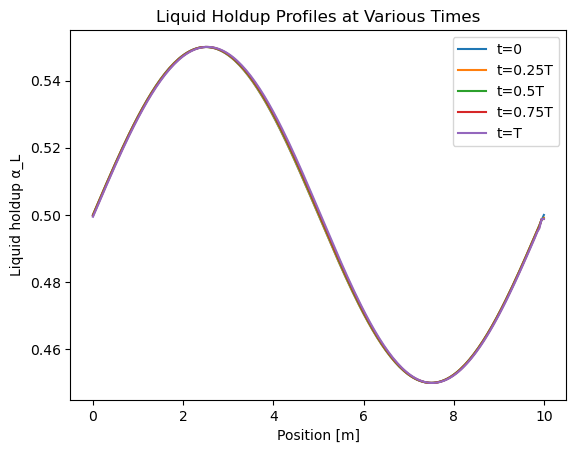

In [73]:
import numpy as np
import matplotlib.pyplot as plt

data = np.load("two_phase_with_geometry.npz")
all_data = data['states']
geometry_data = data['geometry']
L = data['L']
N = int(data['N'])
timesteps = all_data.shape[0] - 1
x = np.linspace(0, L, N+1)

plt.figure()
for frac, label in zip([0, 0.25, 0.5, 0.75, 1.0], ['t=0', 't=0.25T', 't=0.5T', 't=0.75T', 't=T']):
    idx = int(frac * timesteps)
    plt.plot(x, all_data[idx, 0, :], label=label)
plt.xlabel('Position [m]')
plt.ylabel('Liquid holdup α_L')
plt.legend()
plt.title("Liquid Holdup Profiles at Various Times")
plt.show()

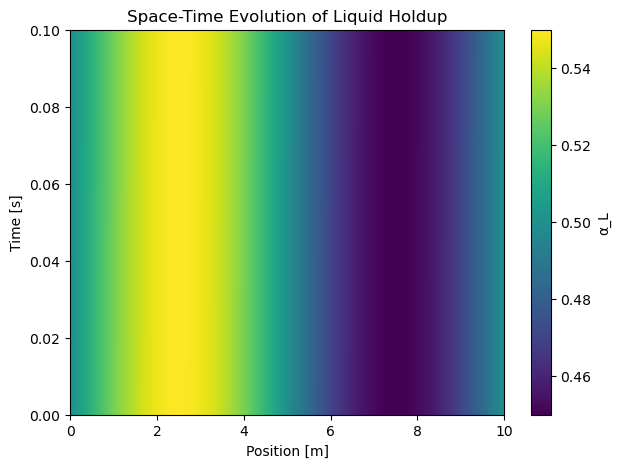

In [53]:
plt.figure(figsize=(7,5))
plt.imshow(all_data[:, 0, :], aspect='auto', extent=[0, L, 0, T], origin='lower', cmap='viridis')
plt.colorbar(label='α_L')
plt.xlabel("Position [m]")
plt.ylabel("Time [s]")
plt.title("Space-Time Evolution of Liquid Holdup")
plt.show()

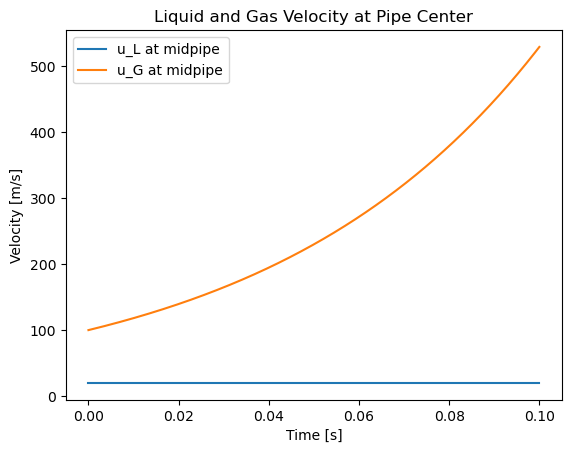

In [54]:
mid_idx = N // 2
plt.plot(np.linspace(0, T, timesteps+1), all_data[:, 1, mid_idx], label='u_L at midpipe')
plt.plot(np.linspace(0, T, timesteps+1), all_data[:, 3, mid_idx], label='u_G at midpipe')
plt.xlabel("Time [s]")
plt.ylabel("Velocity [m/s]")
plt.title("Liquid and Gas Velocity at Pipe Center")
plt.legend()
plt.show()

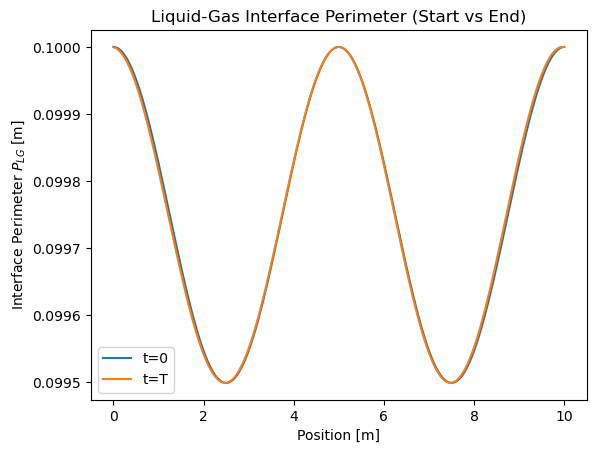

In [33]:
plt.plot(x, geometry_data[0, 2, :], label='t=0')
plt.plot(x, geometry_data[-1, 2, :], label='t=T')
plt.xlabel("Position [m]")
plt.ylabel("Interface Perimeter $P_{LG}$ [m]")
plt.title("Liquid-Gas Interface Perimeter (Start vs End)")
plt.legend()
plt.show()

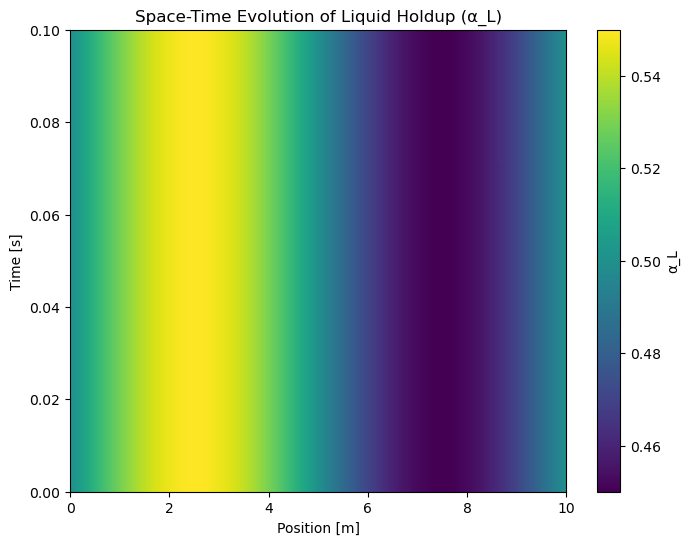

In [44]:
import numpy as np
import matplotlib.pyplot as plt

data = np.load("two_phase_with_geometry.npz")
all_data = data['states']
L = data['L']
N = int(data['N'])
T = data['T']
timesteps = all_data.shape[0] - 1
x = np.linspace(0, L, N+1)

plt.figure(figsize=(8,6))
plt.imshow(all_data[:, 0, :], aspect='auto', extent=[0, L, 0, T], origin='lower', cmap='viridis')
plt.colorbar(label='α_L')
plt.xlabel("Position [m]")
plt.ylabel("Time [s]")
plt.title("Space-Time Evolution of Liquid Holdup (α_L)")
plt.show()

Calling FFC just-in-time (JIT) compiler, this may take some time.


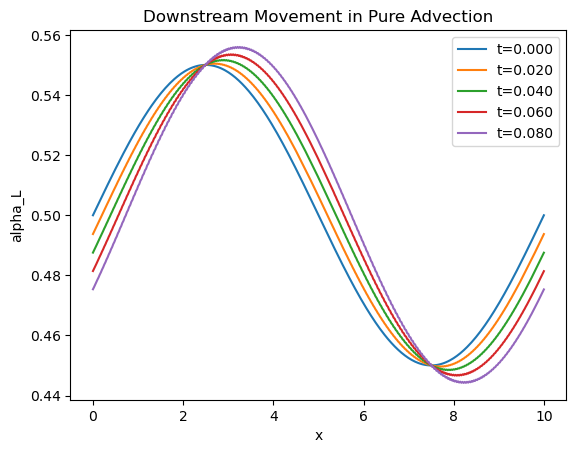

In [48]:
from fenics import *
import numpy as np
import matplotlib.pyplot as plt

set_log_level(30)

N = 200
L = 10.0
mesh = IntervalMesh(N, 0, L)
dt = 1e-4
T = 0.1

V = FunctionSpace(mesh, "DG", 1)
v = TestFunction(V)
alpha_L = TrialFunction(V)

# Use Expression for initial condition (no shape mismatch)
alpha_L0 = interpolate(Expression("0.5 + 0.05*sin(2*pi*x[0]/L)", degree=2, pi=np.pi, L=L), V)

u_advection = 10.0  # Try 10.0 if no visible movement
nu = 1e-4

alpha_L_n = Function(V)
alpha_L_n.assign(alpha_L0)

a = (alpha_L / dt) * v * dx + u_advection * alpha_L.dx(0) * v * dx + nu * dot(grad(alpha_L), grad(v)) * dx
L_form = (alpha_L_n / dt) * v * dx

alpha_L_new = Function(V)
profiles = []
times = []
t = 0.0
timesteps = int(T/dt)
for n in range(timesteps):
    solve(a == L_form, alpha_L_new)
    alpha_L_n.assign(alpha_L_new)
    t += dt
    if n % int(timesteps / 5) == 0:
        # Sample for plotting at high-res points
        plot_points = np.linspace(0, L, 400)
        prof = np.array([alpha_L_new(point) for point in plot_points])
        profiles.append(prof)
        times.append(t)

plt.figure()
for i, prof in enumerate(profiles):
    plt.plot(plot_points, prof, label=f"t={times[i]:.3f}")
plt.legend()
plt.xlabel("x")
plt.ylabel("alpha_L")
plt.title("Downstream Movement in Pure Advection")
plt.show()


Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


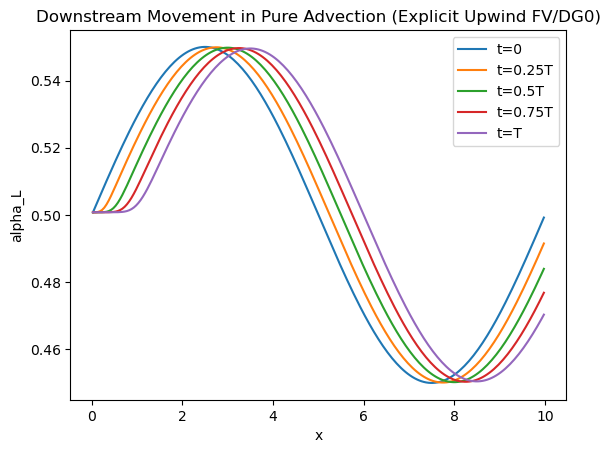

In [66]:
from fenics import *
import numpy as np
import matplotlib.pyplot as plt

set_log_level(30)

N = 200
L = 10.0
mesh = IntervalMesh(N, 0, L)
dx_cell = L / N
u_advection = 20.0
CFL = 0.05  # Much less than 1!
dt = CFL * dx_cell / u_advection
T = 0.05

V = FunctionSpace(mesh, "DG", 0)  # DG0: piecewise constant (finite volume)
x = SpatialCoordinate(mesh)
alpha_L0 = project(0.5 + 0.05 * sin(2 * np.pi * x[0] / L), V)

alpha_L_n = Function(V)
alpha_L_n.assign(alpha_L0)

timesteps = int(T/dt)
all_data = np.zeros((timesteps+1, V.dim()))
cell_centers = np.array([cell.midpoint().x() for cell in cells(mesh)])
all_data[0, :] = alpha_L_n.vector().get_local()

for step in range(1, timesteps+1):
    # Standard upwind FV: α_j^{n+1} = α_j^n - dt/dx * u * (α_j^n - α_{j-1}^n)
    alpha = alpha_L_n.vector().get_local()
    alpha_shift = np.roll(alpha, 1)  # left neighbor; upwind for positive u
    alpha_shift[0] = alpha[0]  # Left boundary: hold fixed

    alpha_new = alpha - dt/dx_cell * u_advection * (alpha - alpha_shift)
    alpha_L_n.vector().set_local(alpha_new)
    all_data[step, :] = alpha_new

plt.figure()
for frac, label in zip([0, 0.25, 0.5, 0.75, 1.0], ['t=0', 't=0.25T', 't=0.5T', 't=0.75T', 't=T']):
    idx = int(frac * timesteps)
    plt.plot(cell_centers, all_data[idx, :], label=label)
plt.xlabel('x')
plt.ylabel('alpha_L')
plt.legend()
plt.title("Downstream Movement in Pure Advection (Explicit Upwind FV/DG0)")
plt.show()